# Time series clustering exercise

# Data

Download the census bureau business data for all years 1993-2014. You can investigate using the API (I have not done it with the census bureau). I did is as you see below

The data is on the github repo. Each file is the economic census for 1 year. 
Download it programmatically and move it to PUIdata

 Download the NYC zipcodes shapefile. One of many ways in which you can get the zipcodes shapefile for NYC
 https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip


## You can use zipfile module in python to unzip the files
it should be installed in your system, but if it is not you can get the code with wget from here
https://github.com/python/cpython/blob/2.7/Lib/zipfile.py
remembering to use the raw link
(or you can use the usual shell commands)

In [143]:
import pandas as pd
import zipfile 
import os
import urllib
from IPython.display import display, HTML
import geopandas as gp
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as pl
import scipy.cluster as scp
from sklearn.cluster import AgglomerativeClustering

% matplotlib inline

In [2]:
#environmental variable
#create the env variable since previous doesn't work
os.environ["PUIDATA"] = "%s/PUI2018/PUIdata"%os.getenv("HOME")

print("PUIdata", os.getenv("PUIDATA"))

PUIdata /nfshome/sjf374/PUI2018/PUIdata


In [3]:
def zips(filename):
    print ("Downloading")
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + filename + ".zip"):
        print ("no zip in puidata")
        if not os.path.isfile(filename + ".zip"):
            print ("no zip in current folder")
            urllib.request.urlretrieve('https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/' + filename + '.zip', filename + '.zip')                  

        os.system("mv " + filename + ".zip " + os.getenv("PUIDATA"))
        print ("moving zipped file")
    
    zf = zipfile.ZipFile(os.getenv("PUIDATA") + "/" + filename + ".zip")
    df = pd.read_csv(zf.open(filename + ".zip".replace('.zip','.txt')))

    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + filename + ".zip"):
        print ("WARNING!!! something is wrong: the %s file is not there!" % (x))

    else:
        print ("file in place, you can continue")
    
    return df

In [4]:
years = [x for x in range(94,100)] + [x for x in range(15)]

In [5]:
years

[94, 95, 96, 97, 98, 99, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [6]:
for x in years:  
    # https://stackoverflow.com/questions/3505831/in-python-how-do-i-convert-a-single-digit-number-into-a-double-digits-string
    print ("{0:0=2d}".format(x))

94
95
96
97
98
99
00
01
02
03
04
05
06
07
08
09
10
11
12
13
14


In [7]:
i = 0
for x in years:  
    # https://stackoverflow.com/questions/3505831/in-python-how-do-i-convert-a-single-digit-number-into-a-double-digits-string
    x = "{0:0=2d}".format(x)
    filename = 'zbp' + x + 'totals'
    current_df = zips(filename)
    # lowercase columns
    current_df.columns = [x.lower() for x in current_df.columns]
    # filtering columns
    current_df = current_df[['zip', 'est']]
    #renaming columns to account for different years
    current_df.columns = ['zip', x]
    current_df['zip'] = current_df['zip'].astype(int).astype(str)
    # if first file than no need to merge
    if i == 0:
        master_df = current_df
    #second file and forward merge on zip
    else:
        master_df = master_df.merge(current_df, on='zip', how='outer')
    i=+1

Downloading
file in place, you can continue
Downloading
file in place, you can continue
Downloading
file in place, you can continue
Downloading
file in place, you can continue
Downloading
file in place, you can continue
Downloading
file in place, you can continue
Downloading
file in place, you can continue
Downloading
file in place, you can continue
Downloading
file in place, you can continue
Downloading
file in place, you can continue
Downloading
file in place, you can continue
Downloading
file in place, you can continue
Downloading
file in place, you can continue
Downloading
file in place, you can continue
Downloading
file in place, you can continue
Downloading
file in place, you can continue
Downloading
file in place, you can continue
Downloading
file in place, you can continue
Downloading
file in place, you can continue
Downloading
file in place, you can continue
Downloading
file in place, you can continue


In [9]:
master_df.head()

,zip,94,95,96,97,98,99,00,01,02,...,05,06,07,08,09,10,11,12,13,14
0,1001,439.0,439.0,433.0,457.0,444.0,469.0,493.0,490.0,490.0,...,509.0,509.0,503.0,477.0,458.0,448.0,436.0,453.0,439.0,458.0
1,1002,450.0,467.0,487.0,500.0,490.0,558.0,563.0,587.0,566.0,...,589.0,582.0,596.0,584.0,571.0,570.0,558.0,572.0,572.0,560.0
2,1003,10.0,10.0,13.0,15.0,14.0,13.0,13.0,13.0,15.0,...,12.0,12.0,16.0,17.0,16.0,16.0,16.0,15.0,15.0,18.0
3,1004,47.0,48.0,47.0,41.0,31.0,35.0,48.0,37.0,23.0,...,31.0,30.0,20.0,18.0,18.0,21.0,19.0,16.0,16.0,13.0
4,1005,92.0,95.0,101.0,104.0,95.0,82.0,86.0,90.0,94.0,...,94.0,98.0,106.0,97.0,87.0,96.0,91.0,94.0,97.0,97.0


In [10]:
master_df.shape

(42672, 22)

In [11]:
#going with zip code method instead

# nyny = ['NEW YORK, NY',     
# 'BROOKLYN, NY', 
# 'BRONX, NY', 
# 'JAMAICA, NY', 
# 'STATEN ISLAND, NY', 
# 'FLUSHING, NY', 
# 'FAR ROCKAWAY, NY', 
# 'ASTORIA, NY']

#filter down the data to the 9 places listed above
# for k in bd_dfs:
#     bd_dfs[k] = bd_dfs[k][[x in nyny for x in bd_dfs[k]['name']]]

#double check that there are the right amount of zips
#bd_dfs['zbp01totals'][[x in nyny for x in bd_dfs['zbp01totals']['name']]]['zip'].unique()


# Data cleaning

you may need to clean your data: for some NYC zip codes there may be no info
sanity check: you should have 20 (N_timestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)


IMPORTANT: read the instructions below on pre-processing. Afte rthat:

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



## TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means
    in **a few** clusters (as discussed there is no real good, sound way to 
    decide what a good number is here. try a few options, keeping in mind 
    a few is more than a couple, but i recommand you stay within the 
    single digit numbers)
    
    3. plot the cluster centers (if you used K means those are the means of 
    the clusters). you can plot for example the cluster centers overlayed on 
    each time series (using the alpha channel to control the opacity in the 
    plot may be helpful here).
    
    4. Use another clustering algorithm (of your choice)
    
    5. overlay your data on a NYC map: you can use shapefiles for the 
    zip codes and different colors for different clusters
    
    6. Compare the results of the 2 algorithms
    
    7. attempt an interpretation. this is dangerous ground: clustering is 
    an exploratory tool so you do not want to jump to conclusions because 
    you see some clusters! but seeing structure in your data can inform 
    your next moves as an investigator. 
    

Note on preprocessing: the preparation of these data should include the "standardization" of the time seris. 
*Always when you apply a moachine learning model you should standardize the data or whiten it.*
These operations may be complicated preprocessing operation, they can for example invoke PCA, and they are aimed at removing covariance in the feature space.

The simplest version of whitening *standardizes each feature*" from every column (feature) you subtract the mean and you divide it by the standard deviation.

But the time series preprocessing is different if you want to use each time stamp as feature: because you want to maintain the coherence of the data, i.e. you **do not want** to treat each feature as an independent feature! the pattenrs in the time series are what you are clustering on (time series goes up and down, creating a pattern) and those patterns would be lost by whitening.

*So when you cluster or otherwise use a time series in a model, using each timestamp as a feature, you want to standardize the observations, not the features.* 

**From each row of your table (observation, in this case each zipcode) subtract the mean and you divide the row by the standard deviation.**

In [12]:
# https://data.cityofnewyork.us/api/views/i8iw-xf4u/files/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip
# Get the zipcodes shapefile
url = "https://data.cityofnewyork.us/api/views/i8iw-xf4u/files/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip"
urllib.request.urlretrieve(url, "ZIP_CODE_040114.zip")
!unzip -d $PUIDATA ZIP_CODE_040114.zip

Archive:  ZIP_CODE_040114.zip
replace /nfshome/sjf374/PUI2018/PUIdata/ZIP_CODE_040114.shx? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [13]:
nyczipsshp = gp.read_file(os.getenv("PUIDATA") + "/ZIP_CODE_040114.shp")
#nyczipsshp.plot()
#nyczipsshp.drop_duplicates("ZIPCODE").plot()
#nyczipsshp
print("ZIPCODES:",
      len(np.unique(nyczipsshp.ZIPCODE)), "POLYGONS:",
      len(nyczipsshp.ZIPCODE),
      "the difference is due to island with same zip as parts of land,",
      "but disjoint shapes")
nyczips = nyczipsshp.ZIPCODE.values.astype(int)
print("number of NYC zip codes:", len(nyczips))

ZIPCODES: 248 POLYGONS: 263 the difference is due to island with same zip as parts of land, but disjoint shapes
number of NYC zip codes: 263


In [14]:
zipcodes = list(nyczipsshp['ZIPCODE'].unique())

In [15]:
len(zipcodes)

248

In [16]:
master_df['zip'] = master_df['zip'].astype(int).astype(str)

In [17]:
csb = master_df[[x in zipcodes for x in master_df['zip']]]

In [18]:
csb.head()

,zip,94,95,96,97,98,99,00,01,02,...,05,06,07,08,09,10,11,12,13,14
2966,10001,6999.0,7088.0,7075.0,7154.0,7254.0,7233.0,7317.0,7188.0,7141.0,...,7312.0,7415.0,7549.0,7472.0,7305.0,7241.0,7227.0,7235.0,7273.0,7369.0
2967,10002,1784.0,1819.0,1919.0,2049.0,2003.0,2085.0,2277.0,2543.0,2269.0,...,2682.0,2686.0,2685.0,2691.0,2775.0,2872.0,2912.0,2954.0,2988.0,2972.0
2968,10003,3256.0,3377.0,3417.0,3535.0,3649.0,3659.0,3683.0,3602.0,3616.0,...,3867.0,3909.0,4049.0,4071.0,4099.0,4113.0,4159.0,4214.0,4277.0,4333.0
2969,10004,1115.0,1124.0,1133.0,1173.0,1176.0,1233.0,1294.0,1247.0,1253.0,...,1260.0,1311.0,1370.0,1376.0,1379.0,1398.0,1404.0,1442.0,1479.0,1554.0
2970,10005,1076.0,1109.0,1216.0,1227.0,1270.0,1242.0,1287.0,1249.0,1244.0,...,1214.0,1259.0,1273.0,1291.0,1274.0,1266.0,1301.0,1273.0,1296.0,1321.0


In [19]:
csb.shape

(245, 22)

In [20]:
cleancsb = csb.dropna()

In [21]:
cleancsb.shape

(230, 22)

In [22]:
cleancsb.reset_index(drop=True, inplace=True)

In [23]:
pd.set_option("display.max_columns",30)

In [24]:
cleancsb.head()

,zip,94,95,96,97,98,99,00,01,02,03,04,05,06,07,08,09,10,11,12,13,14
0,10001,6999.0,7088.0,7075.0,7154.0,7254.0,7233.0,7317.0,7188.0,7141.0,7084.0,7370.0,7312.0,7415.0,7549.0,7472.0,7305.0,7241.0,7227.0,7235.0,7273.0,7369.0
1,10002,1784.0,1819.0,1919.0,2049.0,2003.0,2085.0,2277.0,2543.0,2269.0,2402.0,2551.0,2682.0,2686.0,2685.0,2691.0,2775.0,2872.0,2912.0,2954.0,2988.0,2972.0
2,10003,3256.0,3377.0,3417.0,3535.0,3649.0,3659.0,3683.0,3602.0,3616.0,3704.0,3776.0,3867.0,3909.0,4049.0,4071.0,4099.0,4113.0,4159.0,4214.0,4277.0,4333.0
3,10004,1115.0,1124.0,1133.0,1173.0,1176.0,1233.0,1294.0,1247.0,1253.0,1252.0,1283.0,1260.0,1311.0,1370.0,1376.0,1379.0,1398.0,1404.0,1442.0,1479.0,1554.0
4,10005,1076.0,1109.0,1216.0,1227.0,1270.0,1242.0,1287.0,1249.0,1244.0,1200.0,1226.0,1214.0,1259.0,1273.0,1291.0,1274.0,1266.0,1301.0,1273.0,1296.0,1321.0


In [107]:
# TODO visit differences in row counts between professor and mine

In [33]:
# # 20 years of data and 263 zipcodes
# cbs.shape

NameError: name 'cbs' is not defined

In [13]:
# #cleaning all missing values
# cleancsb.shape

(260, 20)

In [25]:
#then the standardization will look like:
vals = ((cleancsb.iloc[:,1:].T - cleancsb.iloc[:,1:].mean(1)) / cleancsb.iloc[:,1:].std(1)).T

In [26]:
vals.mean(axis=1)

0     -9.251859e-16
1      2.220446e-16
2     -5.286776e-17
3     -1.691768e-16
4     -1.776357e-15
5      1.057355e-17
6     -5.498247e-16
7      1.586033e-16
8      2.960595e-16
9     -1.173664e-15
10     1.020348e-15
11     1.928021e-16
12    -4.335157e-16
13    -1.875484e-15
14    -8.353107e-16
15     1.374562e-15
16     7.137148e-16
17     6.396999e-16
18     3.277801e-16
19     1.215959e-15
20     1.533165e-15
21     0.000000e+00
22    -6.344132e-17
23     9.516197e-17
24    -2.326182e-16
25     9.529414e-16
26    -8.458842e-17
27    -2.326182e-16
28     2.749124e-16
29    -3.172066e-16
           ...     
200   -6.344132e-17
201   -4.758099e-16
202   -3.172066e-16
203    2.008975e-16
204   -1.839798e-15
205   -6.132661e-16
206   -7.718693e-16
207    4.229421e-17
208    8.035900e-16
209   -5.286776e-17
210    5.286776e-17
211    3.383537e-16
212    8.670313e-16
213   -1.691768e-16
214   -2.114711e-17
215   -3.172066e-16
216   -5.392512e-16
217    4.440892e-16
218    3.674310e-16


In [27]:
vals.mean(axis=1).shape

(230,)

In [28]:
vals.std(axis=1)

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
5      1.0
6      1.0
7      1.0
8      1.0
9      1.0
10     1.0
11     1.0
12     1.0
13     1.0
14     1.0
15     1.0
16     1.0
17     1.0
18     1.0
19     1.0
20     1.0
21     1.0
22     1.0
23     1.0
24     1.0
25     1.0
26     1.0
27     1.0
28     1.0
29     1.0
      ... 
200    1.0
201    1.0
202    1.0
203    1.0
204    1.0
205    1.0
206    1.0
207    1.0
208    1.0
209    1.0
210    1.0
211    1.0
212    1.0
213    1.0
214    1.0
215    1.0
216    1.0
217    1.0
218    1.0
219    1.0
220    1.0
221    1.0
222    1.0
223    1.0
224    1.0
225    1.0
226    1.0
227    1.0
228    1.0
229    1.0
dtype: float64

In [29]:
vals.std(axis=1).shape

(230,)

vals.mean(axis=1) should return 0 (or something very small) everywhere

vals.mean(axis=1).shape should be (260,)

vals.std(axis=1) should return 1 everywhere

vals.std(axis=1).shape

In [30]:
#cluster with kmeans
km = KMeans(n_clusters=5, random_state=666).fit(vals)


In [31]:
#each observation in the km object has a label: 
#that is the cluster assigned to that observation
km.labels_.shape

(230,)

In [32]:
km.labels_

array([0, 0, 4, 4, 0, 2, 3, 4, 3, 0, 0, 2, 0, 3, 2, 4, 2, 0, 2, 2, 0, 0, 0,
       4, 4, 0, 4, 4, 4, 4, 0, 4, 4, 3, 4, 3, 4, 0, 0, 3, 4, 0, 3, 3, 2, 1,
       1, 2, 1, 2, 2, 0, 4, 2, 0, 1, 2, 2, 2, 0, 2, 2, 1, 1, 1, 1, 3, 2, 2,
       4, 1, 2, 3, 4, 2, 2, 4, 2, 2, 1, 2, 2, 3, 4, 3, 0, 2, 0, 2, 0, 4, 4,
       4, 0, 4, 4, 0, 4, 0, 1, 4, 0, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4,
       3, 4, 0, 4, 4, 4, 1, 1, 4, 0, 4, 4, 4, 0, 1, 4, 0, 4, 0, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 1, 4, 4, 0, 4, 4, 4, 0, 4, 4, 0, 4, 4,
       3, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 0, 4, 4, 4, 4, 4, 4, 0, 4, 3, 0, 4,
       4, 4, 4, 4, 4, 4, 0, 1, 4, 4, 0, 0, 0, 0, 4, 4, 4, 3, 4, 4, 4, 4, 0], dtype=int32)

In [46]:
vals['zip'] = cleancsb['zip']

In [47]:
vals.head()

,94,95,96,97,98,99,00,01,02,03,04,05,06,07,08,09,10,11,12,13,14,kmlabels,zip
0,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,0.853243,0.432324,1.179819,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986,0,10001
1,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,0.195965,0.522100,0.532058,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077,0,10002
2,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,-0.162325,0.127855,0.261785,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833,4,10003
3,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,-0.123265,-0.313478,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,4,10004
4,-2.819347,-2.263972,-0.463213,-0.278088,0.445582,-0.025645,0.731684,0.092162,0.008014,-0.732485,-0.294917,-0.496872,0.260457,0.496070,0.799002,0.512900,0.378264,0.967297,0.496070,0.883150,1.303888,0,10005


### The map of the clusters may look something like this

In [ ]:
df.USA.plot(legend=True) #plot usa column
plt.show()

In [106]:
vals[vals['kmlabels'] == x].iloc[:,:-2].mean()

94   -1.291717
95   -1.236570
96   -1.128366
97   -1.001457
98   -0.892096
99   -0.847984
00   -0.735883
01   -0.636465
02   -0.305385
03   -0.182057
04   -0.028423
05    0.105434
06    0.135528
07    0.344506
08    0.475984
09    0.612615
10    0.884966
11    1.060953
12    1.297239
13    1.575107
14    1.794069
dtype: float64

In [75]:
full_years = [x for x in range(1994, 2014+1)]


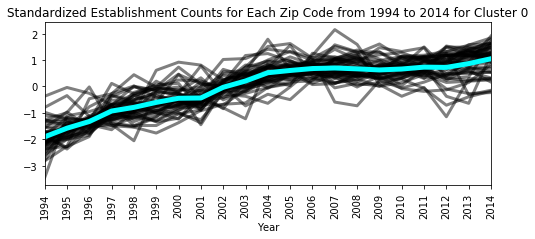

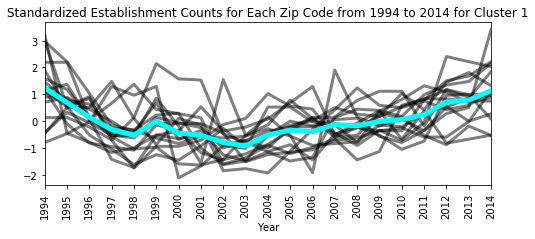

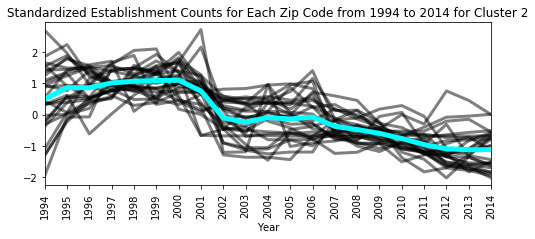

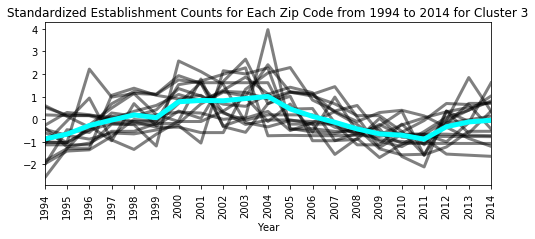

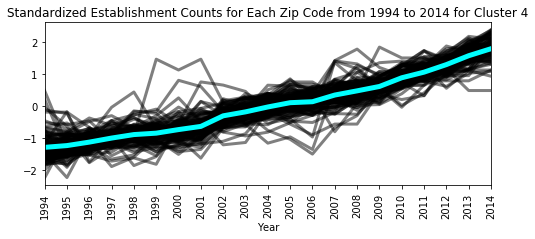

In [110]:
for x in range(5):
    vals[vals['kmlabels'] == x].iloc[:,:-2].T.plot(figsize=(8,3), legend=False, c='black', alpha=0.5, linewidth=3)
    vals[vals['kmlabels'] == x].iloc[:,:-2].mean().plot(c='cyan', linewidth=5)
    pl.title('Standardized Establishment Counts for Each Zip Code from 1994 to 2014 for Cluster %s' % str(x))
    pl.xlabel('Year')
    pl.xticks(np.arange(len(full_years)), full_years, rotation='vertical')
    pl.show()
    
    



Figure 1: we can see here that the kmeans clustering worked quite well as each cluster follows the same trend across the years. It seems there could still be improvements to be made as cluster 4 and 1 have an interesting spike between 1998 and 2001. 

In [127]:
kmean_geo = nyczipsshp[['ZIPCODE', 'geometry']].merge(vals, left_on='ZIPCODE', right_on='zip', how='left')

In [131]:
kmean_geo.dropna(inplace=True)

In [134]:
kmean_geo['kmlabels'] = kmean_geo['kmlabels'].astype(int).astype(str)

Text(0.5,1,'Clusters of Similar Zip Codes by Standardized Establishment Counts Over Time')

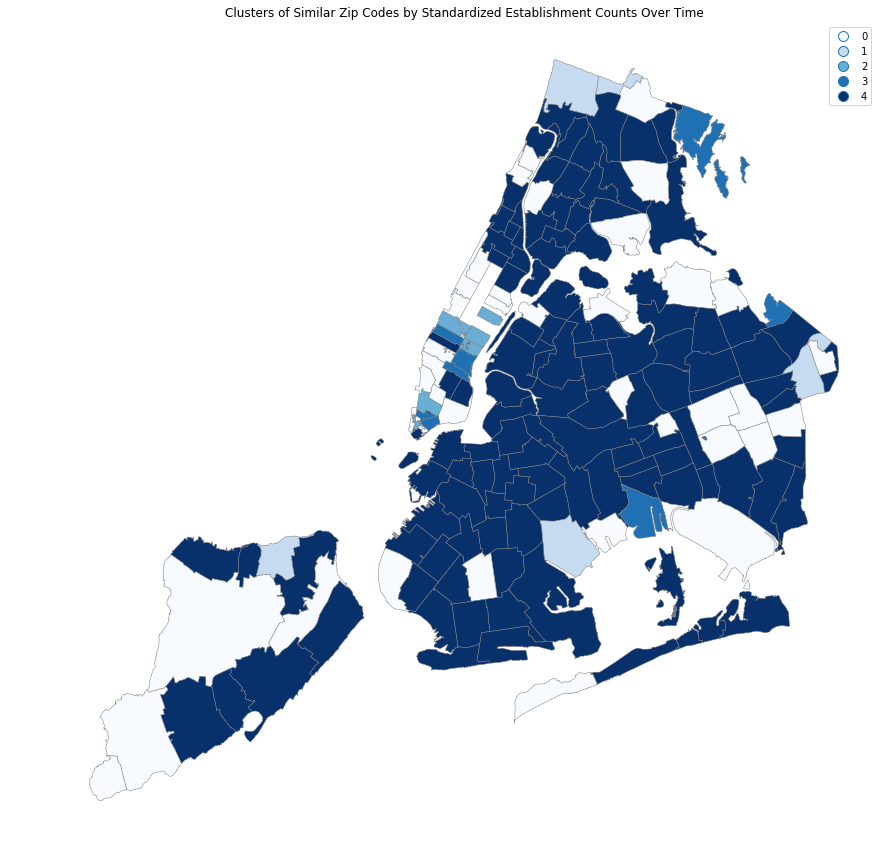

In [138]:
kmean_geo.plot(column='kmlabels', cmap='Blues', ax=ax, legend=True, k=5, edgecolor='grey', lw=0.5, figsize=(15,15))
pl.axis('off')
pl.title('Clusters of Similar Zip Codes by Standardized Establishment Counts Over Time')

#### figure 2: K means Clustering of zipcodes by similarity in time series of counts of establishments over time. Cluster 4 is paticularly of interest here as it encompassed many of the outer boroughs. When looking at the line graph above, it can be seen that all of these areas had growth over the course of 20 years.

### Figure 3: 
cloropleth of  cluster centers for 5 k-means clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. The business pattern time series are plotted at the top.

### or maybe like this, depending on which algorithm you use, and how you proceed to preprocess your data and how you cluster it. There is no one correct answer, but general trends should be retrieved.

(905410.75604293647,
 1075212.5382562787,
 112386.35181947277,
 280345.45402395504)

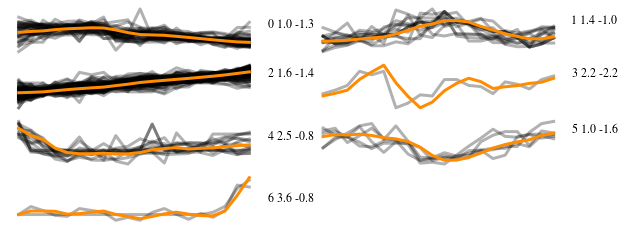

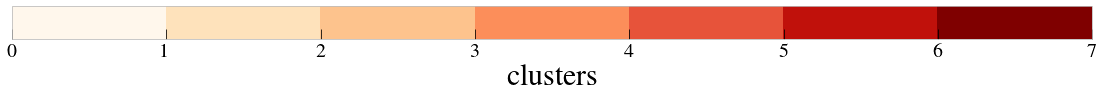

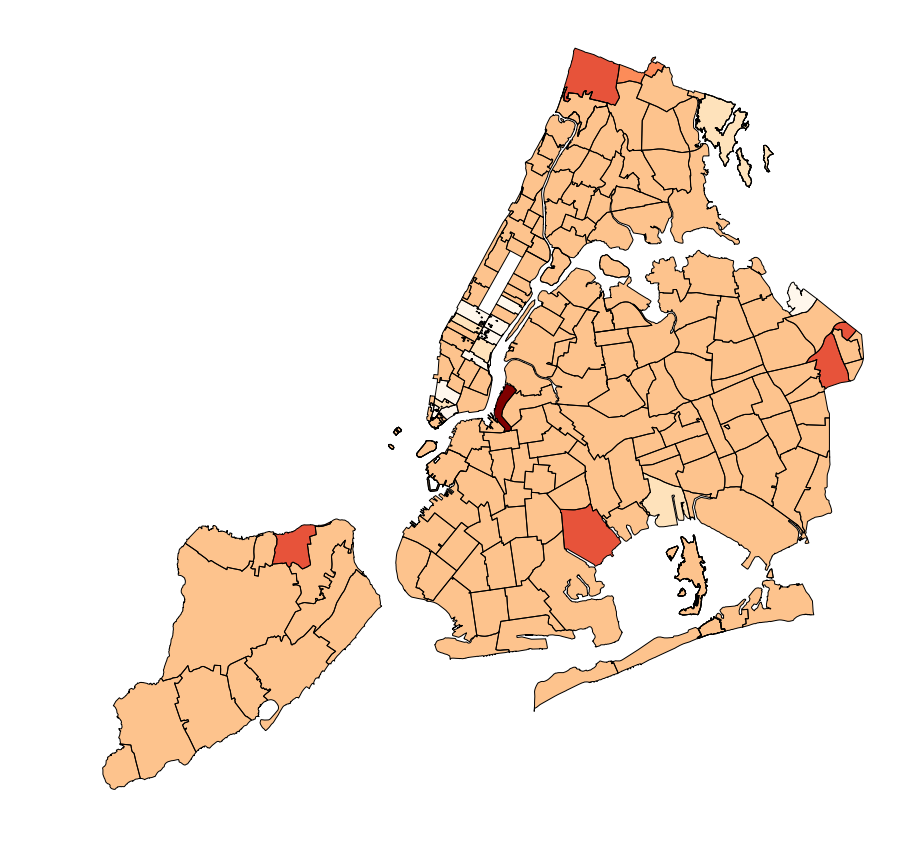

### Figure 9: 
As figures 3, 5, 7 for hierarchical agglomerative clustering in 7 clusters, with smoothed time series

# If you want to use agglomerative clustering

In [161]:
vals_only = vals.iloc[:,:-2]

In [162]:
agc = AgglomerativeClustering(n_clusters=5, linkage='average').fit(vals_only)
labelsag = agc.labels_
centroidsag = np.zeros((5, vals_only.shape[1]))



In [163]:
labelsag

array([2, 2, 2, 2, 2, 3, 0, 2, 0, 2, 2, 4, 2, 0, 3, 2, 3, 0, 3, 3, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 3, 2, 2, 2, 0, 2, 0, 0, 0, 3, 1,
       1, 3, 4, 3, 3, 2, 2, 3, 2, 2, 3, 3, 3, 2, 3, 3, 4, 2, 4, 1, 0, 3, 3,
       2, 4, 3, 0, 2, 4, 3, 2, 3, 3, 2, 3, 3, 0, 2, 0, 2, 3, 2, 3, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2])

In [168]:
vals_agg = pd.concat([vals_only, vals[['zip']]], axis=1)

In [169]:
vals_agg['agg_labels'] = labelsag

In [170]:
vals_agg.head()

,94,95,96,97,98,99,00,01,02,03,04,05,06,07,08,09,10,11,12,13,14,zip,agg_labels
0,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,0.853243,0.432324,1.179819,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986,10001,2
1,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,0.195965,0.522100,0.532058,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077,10002,2
2,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,-0.162325,0.127855,0.261785,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833,10003,2
3,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,-0.123265,-0.313478,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,10004,2
4,-2.819347,-2.263972,-0.463213,-0.278088,0.445582,-0.025645,0.731684,0.092162,0.008014,-0.732485,-0.294917,-0.496872,0.260457,0.496070,0.799002,0.512900,0.378264,0.967297,0.496070,0.883150,1.303888,10005,2


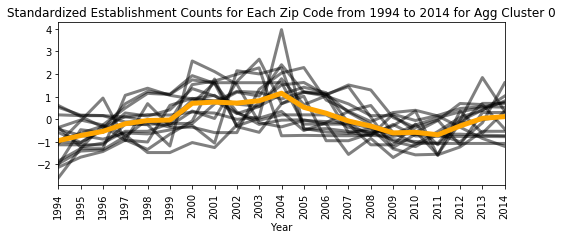

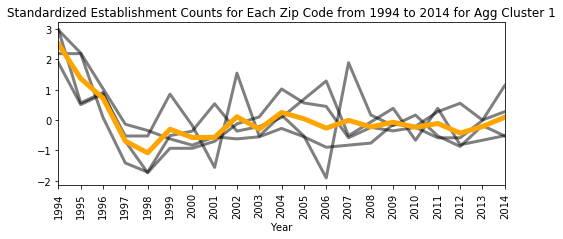

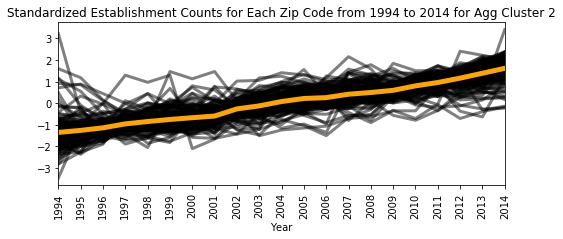

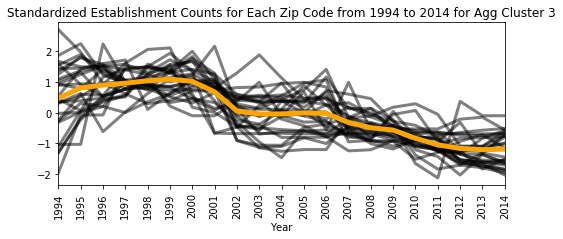

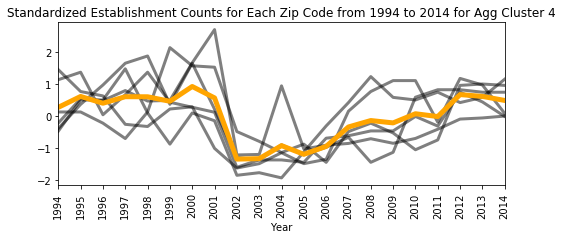

In [173]:
for x in range(5):
    vals_agg[vals_agg['agg_labels'] == x].iloc[:,:-2].T.plot(figsize=(8,3), legend=False, c='black', alpha=0.5, linewidth=3)
    vals_agg[vals_agg['agg_labels'] == x].iloc[:,:-2].mean().plot(c='orange', linewidth=5)
    pl.title('Standardized Establishment Counts for Each Zip Code from 1994 to 2014 for Agg Cluster %s' % str(x))
    pl.xlabel('Year')
    pl.xticks(np.arange(len(full_years)), full_years, rotation='vertical')
    pl.show()

Figure 3: Interesting that there are different outcomes in terms of count of zip codes included per cluster. 

In [174]:
kmean_geo_agg = nyczipsshp[['ZIPCODE', 'geometry']].merge(vals_agg, left_on='ZIPCODE', right_on='zip', how='left')

In [176]:
kmean_geo_agg.dropna(inplace=True)

In [178]:
kmean_geo_agg['agg_labels'] = kmean_geo_agg['agg_labels'].astype(int).astype(str)

Text(0.5,1,'Clusters of Similar Zip Codes by Standardized Establishment Counts Over Time')

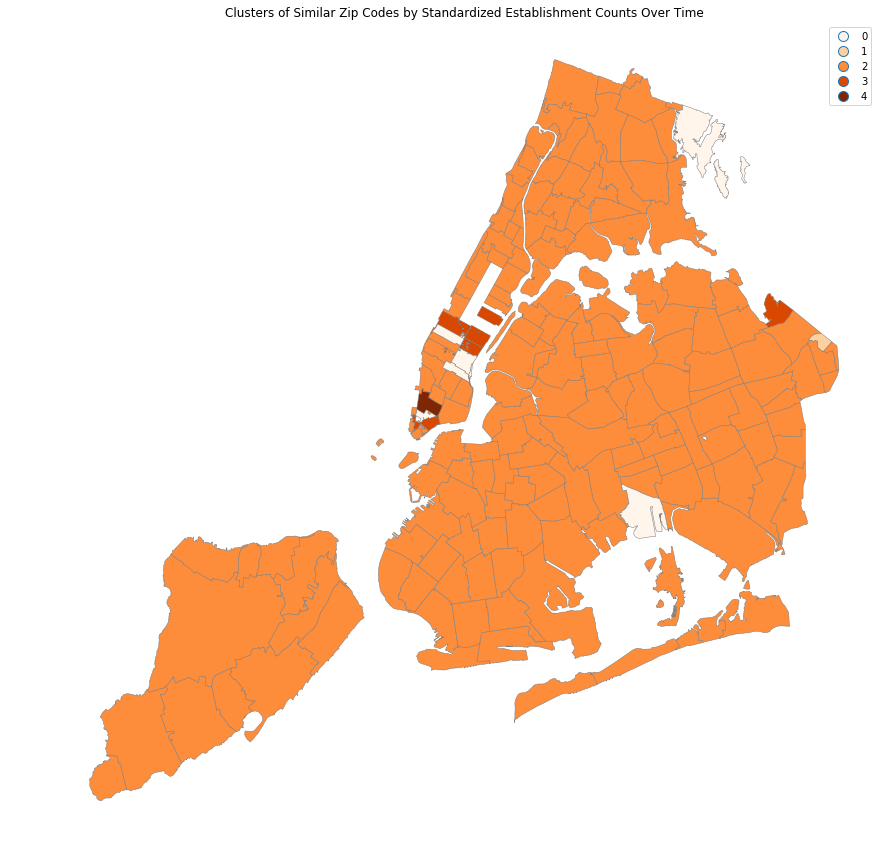

In [179]:
kmean_geo_agg.plot(column='agg_labels', cmap='Oranges', ax=ax, legend=True, k=5, edgecolor='grey', lw=0.5, figsize=(15,15))
pl.axis('off')
pl.title('Clusters of Similar Zip Codes by Standardized Establishment Counts Over Time')

Figure 4: as opposed to the previous map, Here we see a lot more homogoneous assignment.Since agglomerative clustering is a bottom up approach it is looking to pair clusters together and find more homogeneity. We also see that cluster 2 (the cluster with the most zip codes) is the only one that has a clear increase in slope. The others have more of a down or flat trend. 

### And if you use hierarchical clustering in scipy you can make a dandrogram it may look like this:

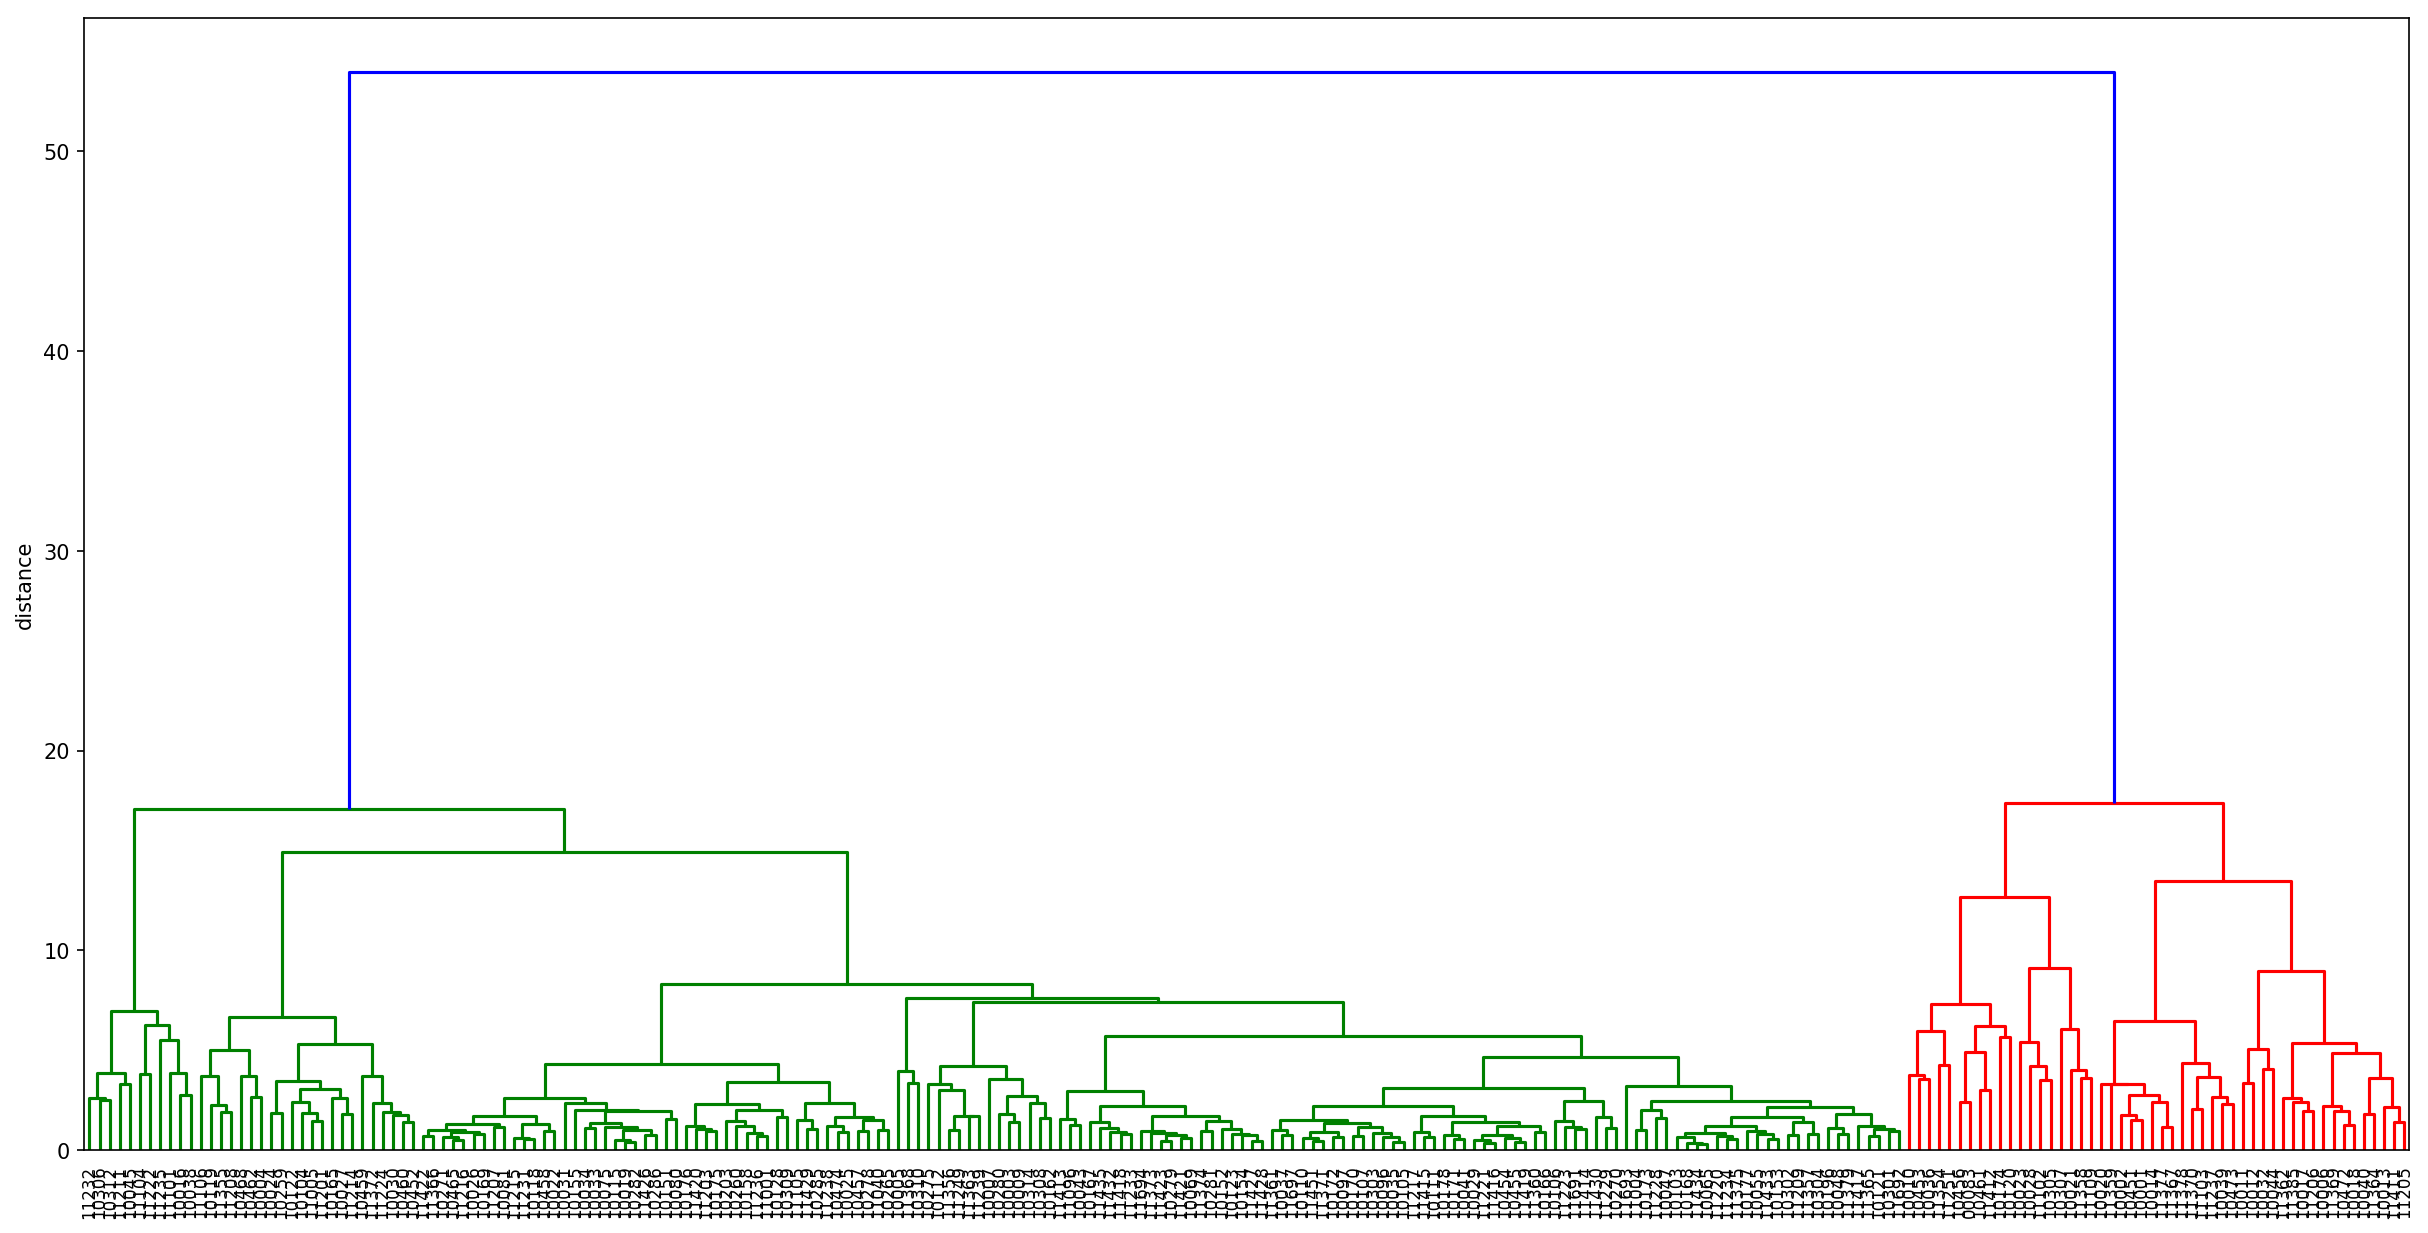

In [158]:
fig = pl.figure(figsize=(20,10), dpi=150)
pl.ylabel("distance")
ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(vals.iloc[:,:-2], method='ward'),
                               labels = zipcodes,
                               leaf_rotation=90.,  # rotates the x axis labels
                               leaf_font_size=8.)  # font size for the x axis labels)
